## CGAS Assignment 1
- Parisha Agrawal | 2021270
- Annu Kumari | 2021312

## Q1) Complete the following analysis using the recipes’ data.

### (a) Scrape (using libraries such as BeautifulSoup) any 10,000 recipes. Submit the raw data. [5]
Include recipe titles, ingredient phrases, cooking instructions, and other relevant details.

In [ ]:
# !pip install requests
# !pip install beautifulsoup4
# !pip install pandas
# !pip install spacy

In [ ]:
import re
import csv
import json
import requests
from bs4 import BeautifulSoup
from requests.adapters import HTTPAdapter, Retry

In [ ]:
recipe_url_rx = r"https://www\.allrecipes\.com/recipe/\d+/.+"
recipes_url_rx = r"https:\/\/www\.allrecipes\.com\/recipes\/\d+\/.+\/"

In [ ]:
def format_prep_time(duration):
    # PT10M to 10 mins
    minutes = re.search(r'(\d+)M', duration)
    hours = re.search(r'(\d+)H', duration)
    days = re.search(r'(\d+)D', duration)

    formatted_duration = []

    if days:
        formatted_duration.append(f"{days.group(1)} days")
    if hours:
        formatted_duration.append(f"{hours.group(1)} hours")
    if minutes:
        formatted_duration.append(f"{minutes.group(1)} mins")

    return " ".join(formatted_duration) if formatted_duration else "No prep time found"

In [ ]:
def parse_urls(s, max_categories):
    recipes_categories = []
    try:
        categories_req = s.get("https://www.allrecipes.com/recipes-a-z-6735880")
    except Exception:
        print("Error in retrieving categories")
        return recipes_categories

    if categories_req.status_code == 200:
        soup = BeautifulSoup(categories_req.text, "html.parser")
        links = soup.find_all("a", class_="mntl-link-list__link")
        for link in links:
            if max_categories == len(recipes_categories):
                break
            href = link.get("href")
            if href and re.match(recipes_url_rx, href):
                recipes_categories.append(href)
    else:
        print("Failed to retrieve categories")

    return recipes_categories

In [ ]:
def get_category(s, category_url):
    try:
        category_req = s.get(category_url)
        return category_req
    except Exception:
        print(f"Failed to retrieve the category: {category_url}")
        return None

In [ ]:
def get_category_recipes_urls(category):
    category_urls = []
    recipes_soup = BeautifulSoup(category.text, "html.parser")
    recipes_soup = recipes_soup.find_all("a", {"class": "card"})
    for recipe_link in recipes_soup:
        if re.match(recipe_url_rx, recipe_link["href"]):
            category_urls.append(recipe_link["href"])
    return category_urls

In [ ]:
def get_recipe(s, recipe_url):
    try:
        recipe_req = s.get(recipe_url)
    except Exception:
        print(f"Failed to retrieve the recipe: {recipe_url}")
        return

    if recipe_req and recipe_req.status_code == 200:
        recipe_soup = BeautifulSoup(recipe_req.text, "html.parser")
        recipe_data = recipe_soup.find("script", {"class": "allrecipes-schema"})

        if recipe_data:
            recipe_json = json.loads(recipe_data.text)[0]
            headline = recipe_json.get("headline", "No headline found")
            recipe_instructions = recipe_json.get("recipeInstructions", [])
            recipe_ingredients = recipe_json.get("recipeIngredient", [])

            # Optionals
            region_cuisine = recipe_json.get("recipeCuisine", "No cuisine found")
            if isinstance(region_cuisine, list):
                region_cuisine = ", ".join(region_cuisine)

            servings = recipe_json.get("recipeYield", "No servings found")
            if isinstance(servings, list):
                servings = ", ".join(servings)

            recipe_prep_time = recipe_json.get("prepTime", "No prep time found")
            formatted_prep_time = format_prep_time(recipe_prep_time)

            # Save to csv
            with open("Q1_a_scraped_recipes.csv", mode="a", newline='', encoding="utf-8") as file:
                writer = csv.writer(file)
                if file.tell() == 0:
                    writer.writerow(["Recipe name", "Recipe URL", "List of ingredient phrases", "List of instructions", "Region/Cuisine", "Servings", "Preparation time"])

                formatted_instructions = [step['text'] for step in recipe_instructions]
                # formatted_ingredients = " ".join(recipe_ingredients)
                writer.writerow([headline, recipe_url, recipe_ingredients, formatted_instructions, region_cuisine, servings, formatted_prep_time])

In [ ]:
def scrape_recipes(s, progress, recipe_categories, max_categories, max_recipes):
    global recipes_count
    for i, category_url in enumerate(recipe_categories):
        if i == max_categories:
            break
        progress["category"] = category_url
        category = get_category(s, category_url)
        if not category:
            continue
        category_urls = get_category_recipes_urls(category)
        progress["category_urls"] = category_urls
        for j, recipe_url in enumerate(category_urls):
            if recipes_count == max_recipes:
                break
            recipes_count += 1
            progress["recipe"] = recipe_url
            get_recipe(s, recipe_url)
            progress["downloaded_count"] += 1
            progress["category_urls"].pop(j)
            if len(progress["categories"]) != 0:
                progress["categories"].pop(i)

In [ ]:
s = requests.Session()
retries = Retry(total=6, backoff_factor=0.1, status_forcelist=[500, 502, 503, 504])
s.mount('http://', HTTPAdapter(max_retries=retries))
s.headers = {"User-Agent": "Mozilla/5.0 (X11 Linux x86_64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome /"}
s.timeout = 12

In [ ]:
max_recipes = 10005
max_categories = 2000
recipes_count = 0
progress = {
    "category": None,
    "recipe": None,
    "downloaded_count": 0,
    "categories": [],
    "category_urls": [],
    "recipe_urls": [],
    "failed_recipes": []
}

In [ ]:
recipe_categories = parse_urls(s, max_categories)

In [ ]:
scrape_recipes(s, progress, recipe_categories, max_categories, max_recipes)

### (b) Write a script to extract information about the ‘name of the ingredients’ from the ingredients section using Named Entity Recognition.

In [1]:
import re
import spacy
import pandas as pd
from spacy.matcher import Matcher

In [2]:
# spaCy's english model
nlp = spacy.load('en_core_web_sm')
matcher = Matcher(nlp.vocab)

In [5]:
pattern = [{"POS": "NOUN"}, {"IS_ALPHA": True, "OP": "?"}]
matcher.add("INGREDIENTS_PATTERN", [pattern])

fluffwords = set([
    'a', 'all', 'an', 'and', 'as', 'beaten', 'baked', 'boiled', 'browned', 'chopped', 'clove', 'coarsely',
    'cold', 'cooked', 'crushed', 'cubed', 'cup', 'cups', 'dash', 'diced', 'divided', 'finely', 'fresh', 'g',
    'garnished', 'gram', 'grams', 'grated', 'ground', 'halved', 'inch', 'kg', 'l', 'large', 'liter', 'liters',
    'melted', 'medium', 'medium-sized', 'minced', 'ml', 'of', 'or', 'ounce', 'ounces', 'package', 'pinch',
    'pound', 'pounds', 'purpose', 'raw', 'roasted', 'shredded', 'slice', 'sliced', 'small', 'steamed',
    'stick', 'sweetened', 'tablespoon', 'tablespoons', 'taste', 'teaspoon', 'teaspoons', 'the', 'thick',
    'thickly', 'thinly', 'to', 'unsalted', 'unsweetened', 'with', 'whole'
])

In [6]:
num_rx = re.compile(r'\b\d+(\.\d+)?\b')
fluffwords_rx = [re.compile(r'\b' + re.escape(fluff) + r'\b') for fluff in fluffwords]

In [7]:
df_recipes = pd.read_csv('Q1_a_scraped_recipes.csv')

In [8]:
# assign random Recipe IDs to all recipes
df_recipes['Recipe ID'] = ['Recipe ' + str(i + 1) for i in range(len(df_recipes))]

In [9]:
def clean_ingredient(ingredient):
    ingredient = re.sub(r'\(.*?\)', '', ingredient)
    for pattern in fluffwords_rx:
        ingredient = pattern.sub('', ingredient)
    ingredient = num_rx.sub('', ingredient)
    ingredient = re.sub(r'\s+', ' ', ingredient).strip()
    return ingredient

def extract_ingredient_entities(ingredient_phrase):
    ingredient_phrase = re.sub(r'\(.*?\)', '', ingredient_phrase)
    for pattern in fluffwords_rx:
        ingredient_phrase = pattern.sub('', ingredient_phrase)
    ingredient_phrase = num_rx.sub('', ingredient_phrase)
    cleaned_text = re.sub(r'\s+', ' ', ingredient_phrase).strip()

    doc = nlp(cleaned_text)
    ingredients = [chunk.text for chunk in doc.noun_chunks] or [cleaned_text]
    cleaned_ingredients = [clean_ingredient(ingredient) for ingredient in ingredients]
    return cleaned_ingredients

In [10]:
# Process ingredient phrases and extract cleaned ingredients
ingredient_data = []
for index, row in df_recipes.iterrows():
    recipe_id = row['Recipe ID']
    ingredient_phrases = eval(row['List of ingredient phrases'])
    for phrase in ingredient_phrases:
        ingredients = extract_ingredient_entities(phrase)
        ingredient_data.extend({'Recipe ID': recipe_id, 'Ingredient': ingredient} for ingredient in ingredients if ingredient)

In [11]:
# save extracted ingredients
ingredient_df = pd.DataFrame(ingredient_data).drop_duplicates()
ingredient_df.to_csv('Q1_b_ingredient_entities.csv', index=False)
print("Ingredient entities saved to 'Q1_b_ingredient_entities.csv'.")

Ingredient entities saved to 'Q1_b_ingredient_entities.csv'.


### (c) Store recipes in the form of a (Recipe ID)—(Ingredient Name) form.

In [12]:
import pandas as pd
import random

In [16]:
df = pd.read_csv('Q1_b_ingredient_entities.csv')
recipe_ids = df['Recipe ID'].unique()

# 100 random recipe IDs
selected_recipe_ids = random.sample(list(recipe_ids), 100)

filtered_df = df[df['Recipe ID'].isin(selected_recipe_ids)]

with open('Q1_c_selected_recipes.txt', 'w') as file:
    # file.write(f"Recipe ID — Ingredient Name\n")
    for _, row in filtered_df.iterrows():
        file.write(f"{row['Recipe ID']} — {row['Ingredient']}\n")

print("Selected recipes-ingredients saved to 'Q1_c_selected_recipes.txt'")

Selected recipes-ingredients saved to 'Q1_c_selected_recipes.txt'


## Q2) Analyze the data obtained for the following.

### (a) Find the number of unique ingredients. List them with their frequencies. Submit the file.

In [17]:
import pandas as pd
import matplotlib.pyplot as plt

In [18]:
df_ingredients = pd.read_csv('Q1_b_ingredient_entities.csv')
ingredient_counts = df_ingredients['Ingredient'].value_counts()

In [19]:
df_ingredient_frequencies = pd.DataFrame({
    'Ingredient Name': ingredient_counts.index,
    'Frequency': ingredient_counts.values
})

In [20]:
df_ingredient_frequencies.to_csv('Q2_a_ingredient_frequencies.csv', index=False)
print("Unique ingredients and their frequencies saved to 'ingredient_frequencies.csv'.")

Unique ingredients and their frequencies saved to 'ingredient_frequencies.csv'.


### (b) Plot the recipe size distribution for these recipes and the average size of the recipes (s).
Properly label the axes. Submit the file.

In [27]:
recipe_sizes = df_ingredients.groupby('Recipe ID').size()
average_size = round(recipe_sizes.mean())

<ipython-input-28-a16fb52969ac>:8: UserWarning: FixedFormatter should only be used together with FixedLocator
  plt.gca().set_yticklabels([f'{(y / 10000)}' for y in plt.gca().get_yticks()])


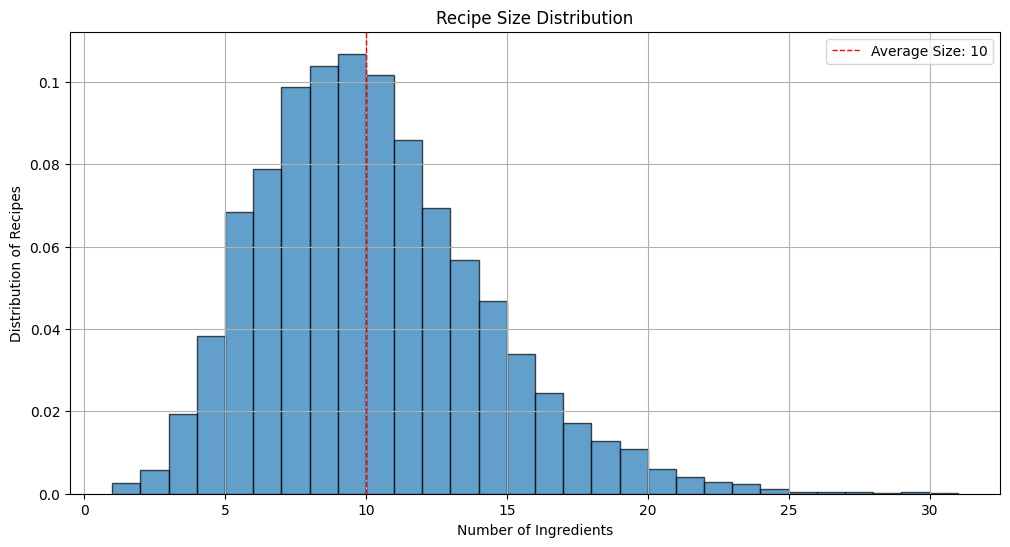

Recipe size distribution plot saved to 'Q2_b_recipe_size_distribution.png'. Average size: 10


In [28]:
# Plot the recipe size distribution
plt.figure(figsize=(12, 6))
plt.hist(recipe_sizes, bins=range(1, recipe_sizes.max() + 2), edgecolor='black', alpha=0.7)
plt.xlabel('Number of Ingredients')
plt.ylabel('Distribution of Recipes')
plt.title('Recipe Size Distribution')
plt.grid(True)
plt.gca().set_yticklabels([f'{(y / 10000)}' for y in plt.gca().get_yticks()])

# Add a line for the average size
plt.axvline(average_size, color='red', linestyle='dashed', linewidth=1, label=f'Average Size: {average_size}')
plt.legend()

# save
plt.savefig('Q2_b_recipe_size_distribution.png')
plt.show()

print(f"Recipe size distribution plot saved to 'Q2_b_recipe_size_distribution.png'. Average size: {average_size}")

In [23]:
# # save
# plt.savefig('Q2_b_recipe_size_distribution.png')
# plt.show()

print(f"Recipe size distribution plot saved to 'Q2_b_recipe_size_distribution.png'. Average size: {average_size}")

<Figure size 640x480 with 0 Axes>

Recipe size distribution plot saved to 'Q2_b_recipe_size_distribution.png'. Average size: 10


### (c) Plot cumulative distribution of recipe size (label axes properly). Submit the file.

In [24]:
# Calculate the cumulative distribution
cumulative_distribution = recipe_sizes.value_counts().sort_index().cumsum()
cumulative_distribution = cumulative_distribution / cumulative_distribution.max()

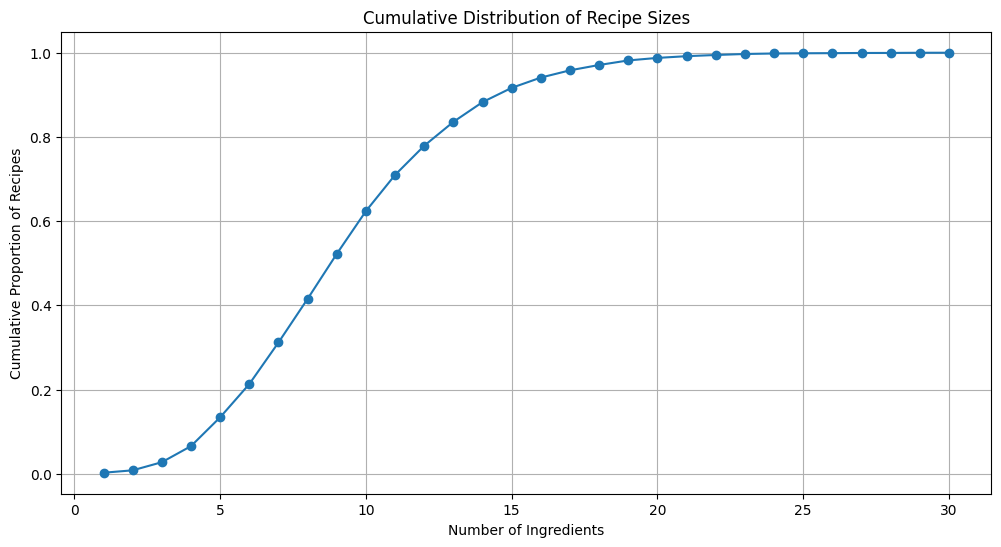

In [29]:
# Plot cumulative distribution
plt.figure(figsize=(12, 6))
plt.plot(cumulative_distribution.index, cumulative_distribution.values, marker='o')
plt.xlabel('Number of Ingredients')
plt.ylabel('Cumulative Proportion of Recipes')
plt.title('Cumulative Distribution of Recipe Sizes')
plt.grid(True)
# save png
plt.savefig('Q2_c_cumulative_distribution.png')
plt.show()

In [26]:
# # save png
# plt.savefig('Q2_c_cumulative_distribution.png')
# plt.show()

print("Cumulative distribution plot saved to 'Q2_cumulative_distribution.png'.")

<Figure size 640x480 with 0 Axes>

Cumulative distribution plot saved to 'Q2_cumulative_distribution.png'.


## Q3) For the data of recipes obtained in the above question (1):


### (a) Plot the frequency-rank distribution. Scale and label axes properly. Submit the file.

In [30]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

In [32]:
df_ingredients = pd.read_csv('Q1_b_ingredient_entities.csv')
ingredient_counts = df_ingredients['Ingredient'].value_counts()

In [33]:
# rank ingredients by their frequency
ranked_ingredients = ingredient_counts.reset_index()
ranked_ingredients.columns = ['Ingredient Name', 'Frequency']
ranked_ingredients['Rank'] = ranked_ingredients['Frequency'].rank(method='min', ascending=False)

# normalise
ranked_ingredients['Normalized Frequency'] = ranked_ingredients['Frequency'] / ranked_ingredients['Frequency'].max()


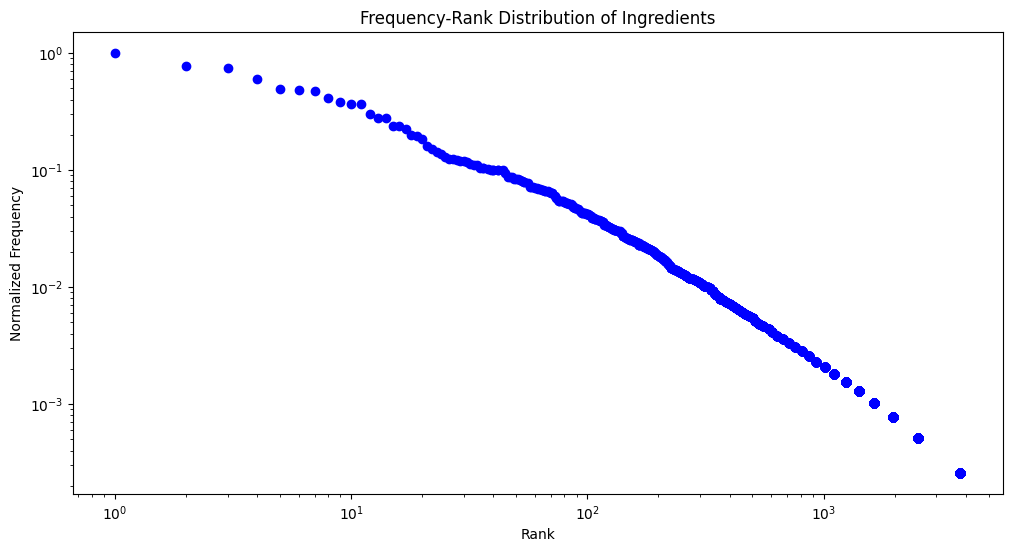

Frequency-rank distribution saved as 'frequency_rank_distribution.svg' and 'frequency_rank_distribution.png'.


In [35]:
# plot the frequency-rank distribution
plt.figure(figsize=(12, 6))

# plot on a logarithmic scale
plt.loglog(ranked_ingredients['Rank'], ranked_ingredients['Normalized Frequency'], marker='o', linestyle='none', color='blue')
plt.xlabel('Rank')
plt.ylabel('Normalized Frequency')
plt.title('Frequency-Rank Distribution of Ingredients')
# save plot png and svg
plt.savefig('Q3_frequency_rank_distribution.png')
plt.savefig('Q3_frequency_rank_distribution.svg')
plt.show()

print("Frequency-rank distribution saved as 'frequency_rank_distribution.svg' and 'frequency_rank_distribution.png'.")